In [104]:
pip install fiftyone torch torchvision fiftyone[torch]


In [105]:
import fiftyone as fo
import fiftyone.zoo as foz

# Load a subset of Open Images dataset with 'Pizza' class
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    label_types=["detections"],
    classes=["Pizza"],
    max_samples=20
)


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v6/validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 20 images


 100% |█████████████████████| 20/20 [2.0s elapsed, 0s remaining, 11.2 files/s]     


INFO:eta.core.utils: 100% |█████████████████████| 20/20 [2.0s elapsed, 0s remaining, 11.2 files/s]     


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading existing dataset 'open-images-v6-validation-20'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v6-validation-20'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [106]:
transform = T.Compose([T.ToTensor()])
torch_dataset = FiftyOneDetectionDataset(dataset, transform=transform)
data_loader = DataLoader(
    torch_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)

In [107]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import numpy as np

class FiftyOneDetectionDataset(Dataset):
    def __init__(self, fiftyone_dataset, transform=None):
        self.dataset = fiftyone_dataset
        self.transform = transform
        self.sample_ids = list(fiftyone_dataset.values("id"))  # store sample IDs

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        sample = self.dataset[sample_id]

        image_path = sample.filepath
        image = Image.open(image_path).convert("RGB")

        boxes = []
        labels = []

        if hasattr(sample.ground_truth, "detections"):
            for det in sample.ground_truth.detections:
                # bounding box in format [x_min, y_min, width, height]
                x, y, w, h = det.bounding_box
                boxes.append([x, y, x + w, y + h])  # convert to [x1, y1, x2, y2]
                labels.append(1)  # single class: pizza

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transform:
            image = self.transform(image)

        return image, target


In [108]:
import torchvision.models.detection as detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # Corrected import

# Load a pre-trained Faster R-CNN model
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier to match the number of classes (1 class: Pizza)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)  # 1 class + background

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [109]:
import torch.optim as optim

# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)


In [110]:
model.train()
for epoch in range(1):  # Training for 1 epoch for demonstration
    # Ensure we are using the corrected data_loader
    for imgs, targets in data_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(imgs, targets)

        # Total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed. Loss: {losses.item()}")

Epoch 1 completed. Loss: 0.3185249865055084


In [111]:
model.eval()
with torch.no_grad():
    img, target = torch_dataset[0]  # get first image
    prediction = model([img.to(device)])



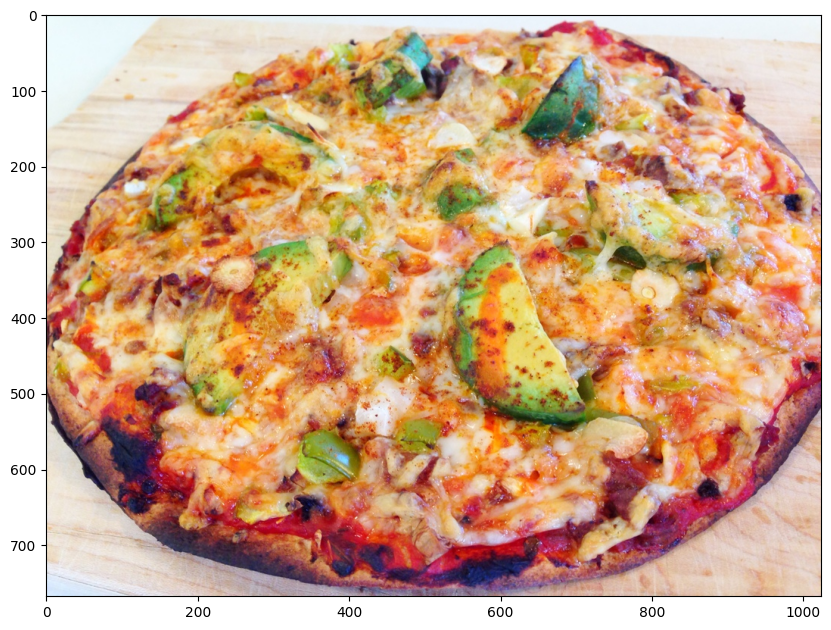

In [112]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T

# Get prediction results
pred_boxes = prediction[0]['boxes'].cpu().numpy()
pred_scores = prediction[0]['scores'].cpu().numpy()
pred_labels = prediction[0]['labels'].cpu().numpy()

# Show image
img_np = img.permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img_np)

# Draw bounding boxes
for box, score in zip(pred_boxes, pred_scores):
    if score > 0.5:  # only show confident detections
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"Pizza: {score:.2f}",
                color="yellow", fontsize=12, backgroundcolor="black")

plt.show()
